<a href="https://colab.research.google.com/github/Abdou-ch-d/Breast-Cancer-Detection/blob/main/DataVisulalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install necessary packages 


In [ ]:
%%capture
!pip install split-folders

In [ ]:
%%capture
!pip install -U albumentations

In [ ]:
%%capture
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [ ]:
%%capture
!pip install --force-reinstall albumentations==1.0.3

In [ ]:
%%capture
!pip install pydicom

In [ ]:
%%capture
!pip install --force-reinstall opencv-python-headless==4.1.2.30

In [ ]:
%%capture
!pip install --upgrade xlrd

In [ ]:
%%capture
!pip install --upgrade pandas

In [ ]:
%%capture
!pip install --upgrade matplotlib

In [ ]:
%%capture
!pip install pypng

In [ ]:
%%capture
!unzip '/content/drive/MyDrive/INBreast_Dataset/INbreast Release 1.0.zip'

In [ ]:
# %%capture
# !unzip '/content/drive/MyDrive/INBreast_Dataset/Micros_Dataset.zip'

# !cp -v '/content/content/Inbreast_data' -r 'Dataset'
# !rm -r '/content/content/'
# !rm -r '/content/Dataset/AllOriginals'
# !mv '/content/Dataset/AllSynthetized' '/content/Dataset/images'
# !mv '/content/Dataset/AllMasks' '/content/Dataset/masks'

In [ ]:
exit()

# Imports

In [ ]:
import numpy as np
import random

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
import pydicom 
from skimage.draw import polygon
import png

import re
import os, shutil
from glob import glob

from tqdm.notebook import tqdm, trange

In [ ]:
from pathlib import Path
import albumentations as A
import plistlib

# Functions

**This function loads a osirix xml region as a binary numpy array for INBREAST
  dataset**

return: numpy array where each mass has a different number id

In [ ]:
#@title load_inbreast_mask{form-width: "1%"}
def load_inbreast_mask(mask_path, imshape=(4084, 3328)):
    """
    @mask_path : Path to the xml file
    @imshape : The shape of the image as an array e.g. [4084, 3328]
    """

    def load_point(point_string):
        x, y = tuple([float(num) for num in point_string.strip('()').split(',')])
        return y, x
    i =  0
    mask = np.zeros(imshape)
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        for roi in rois:
            numPoints = roi['NumberOfPoints']
            if roi['Name'] == 'Calcification':
                i+=1
                points = roi['Point_px']
                assert numPoints == len(points)
                points = [load_point(point) for point in points]
                if len(points) <= 2:
                    for point in points:
                        mask[int(point[0]), int(point[1])] = i
                else:
                    x, y = zip(*points)
                    x, y = np.array(x), np.array(y)
                    poly_x, poly_y = polygon(x, y, shape=imshape)
                    mask[poly_x, poly_y] = i
        

    return mask

**Convert a mask into albumentations format**


mass_mask : numpy array mask where each pixel correspond to a lesion (one pixel id per lesion)

In [ ]:
#@title mask_to_yolo{form-width: "1%"}
def mask_to_yolo(mass_mask):
    """
    return: a list of list containing masses bounding boxes in YOLO coordinates:
            <x> = <absolute_x> / <image_width>
            <y> = <absolute_y> / <image_height>
            <height> = <absolute_height> / <image_height>
            <width> = <absolute_width> / <image_width>
    """
   
    ids=np.unique(mass_mask)[1:]
    res = []
    height, width = mass_mask.shape
    nbr_mass = len(np.unique(mass_mask))-1
    
    
    for i in range(nbr_mass):
        mask = mass_mask.copy()
        mask[mass_mask!=ids[i]]=0
        #find contours of each mass
        cnts, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #create a bbox around the contours
        x, y, w, h = cv2.boundingRect(cnts[0])
        #convert to yolo coordinate system
        # x = x+w//2 -1
        # y= y+h//2 -1
        # res.append([x/width,y/height,w/width,h/height, 'Calcification'])
        res.append([x,y,w,h, 'calcification'])
    return res

**write  the list of bbox into txt file**

In [ ]:
#@title bbox_to_txt{form-width: "1%"}
def bbox_to_txt(bboxes):
    """
    bboxes : numpy array of bounding boxes 
    return : a string for each object in new line: <object-class> <x> <y> <width> <height>
    """
    txt=''
    for l in bboxes:
        l = [str(x) for x in l[:4]]
        l = ' '.join(l)
        txt += '0 ' + l + '\n'
    return txt

# Image processing

**Crop breast ROI from image**  

This can be done with OpenCV and Otsu’s thresholding technique

In [ ]:
#@title crop{form-width: "1%"}
def crop(img, mask):
    """
    @img : numpy array image
    @mask : numpy array mask of the lesions
    return: numpy array of the ROI extracted for the image, 
            numpy array of the ROI extracted for the breast mask,
            numpy array of the ROI extracted for the masses mask
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img,(5,5),0)
    blur=blur.astype(np.uint8)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return img[y:y+h, x:x+w], breast_mask[y:y+h, x:x+w], mask[y:y+h, x:x+w]

**3 preprocessing steps**


*   Truncation normalization
*   Image enhancement
*   Image synthesizing




**Clip and normalize pixels in the breast ROI**

After cropping, the image is still composed of many **black pixels**. This may have negative effects on the detection if we normalize the image as it is (because the breast region will appear less intense). Here the goal is to normalize the **intensity distribution of the pixels** in the breast region.

In [ ]:
#@title truncation_normalization{form-width: "1%"}
def truncation_normalization(img, mask):
    """
    *img : numpy array image
    *mask : numpy array mask of the breast
    return: numpy array of the normalized image
    """
    Pmin = np.percentile(img[mask!=0], 5)
    Pmax = np.percentile(img[mask!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[mask==0]=0
    return normalized

**Image enhancement**

To enhance the contrast of the breast region and so the mass lesion, Contrast Limited Adaptive Histogram Equalization (**CLAHE**) algorithm is applied with clip limit



In [ ]:
#@title clahe{form-width: "1%"}
def clahe(img, clip):
    """
    img : numpy array image
    clip : float, clip limit for CLAHE algorithm
    return: numpy array of the enhanced image
    """
    # img=img.astype('uint8')
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

**Image synthesizing**

Create a 3-channel image composed of the truncated and normalized image,
the contrast enhanced image with clip limit 1, 
and the contrast enhanced image with clip limit 2 

In [ ]:
#@title synthetized_images{form-width: "1%"}
def synthetized_images(DCM_PATH,XML_PATH,patient_id):
    """
    @patient_id : patient id to recover image and mask in the dataset
    return: numpy array of the breast region
            numpy array of the synthetized images
            numpy array of the masses mask
    """
    image_path = glob(os.path.join(DCM_PATH,str(patient_id)+'*.dcm'))[0]
    mass_mask = load_inbreast_mask(os.path.join(XML_PATH,str(patient_id)+'.xml'))
    ds = pydicom.dcmread(image_path)
    pixel_array_numpy = ds.pixel_array


    breast, mask, mass_mask = crop(pixel_array_numpy, mass_mask)
    
    normalized = truncation_normalization(breast, mask)

    cl1 = clahe(normalized, 1.0)
    cl2 = clahe(normalized, 2.0)
   
    synthetized = cv2.merge((np.array(normalized*255, dtype=np.uint8),cl1,cl2))
    mass_mask= mass_mask.astype("uint8")

    breast=cv2.resize(normalized, (256,256))
    breast=cv2.merge((breast, breast, breast))

    mass_mask=cv2.resize(mass_mask, (256,256))

    bnCalc= len(np.unique(mass_mask))-1
    background= np.unique(mass_mask)[0]
    if  not background:
          print("background value:", background)

          f=plt.figure(figsize=(20,15))

          # f.add_subplot(251)
          # plt.imshow(pixel_array_numpy, cmap='gray')
          # plt.title(f"Original img{pixel_array_numpy.max()}")

          # f.add_subplot(262)
          # plt.imshow(breast, cmap='gray')
          # plt.title(f"breast img: {breast.max()}")
          
          # f.add_subplot(263)
          # plt.imshow(normalized, cmap='gray')
          # plt.title("norm img")
          
          # f.add_subplot(264)
          # plt.imshow(cl1, cmap='gray')
          # plt.title("cl1 img")
          
          # f.add_subplot(265)
          # plt.imshow(cl2, cmap='gray')
          # plt.title("cl2 img")

          # f.add_subplot(266)
          # plt.imshow(synthetized)
          # plt.title("synthetized img")

          f.add_subplot(131)
          plt.imshow(breast[:,:,0], cmap='gray')
          plt.title("breast img")

          f.add_subplot(132)
          plt.imshow(breast, cmap='gray')
          plt.title("resized breast img")

          f.add_subplot(133)
          plt.imshow(synthetized)
          plt.title(f"synthetized img:{synthetized.max()}")

    return breast, synthetized, mass_mask, background, bnCalc

In [ ]:
def get_id(XML_PATH):
  
    xmls=glob('/content/Datasets/INbreast Release 1.0/AllXML/*')
    ls=[]
    for x in xmls :
      ls.append(x.split('/')[-1].split('.')[0])

    return ls

p:probability of applying the transform

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90,interpolation=1,border_mode=cv2.BORDER_CONSTANT,value=0, mask_value=0,p=0.5)
    # A.SafeRotate(border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0,p=0.5)  #.geometric.rotate.SafeRotate
    # A.ShiftScaleRotate(scale_limit = 0, rotate_limit=180, p=1, border_mode=0  )
],
#  bbox_params=A.BboxParams(format='yolo' , min_visibility=0.1),

)

In [ ]:
DCM_PATH = '/content/Datasets/INbreast Release 1.0/AllDICOMs/'
XML_PATH = '/content/Datasets/INbreast Release 1.0/AllXML/'

seed= 40 #to generate a different dataset

#Augmentation 

In [ ]:
# Split the data into train val & test set
train_set,val_set  = train_test_split(Callcification_PATIENT_ID, test_size = 0.11, random_state=seed)
# train_set, test_set = train_test_split(train_set, test_size = 0.11, random_state=seed)

shutil.rmtree('data/', ignore_errors = True) 
Path('data/train').mkdir(parents=True, exist_ok=True)
Path('data/validation').mkdir(parents=True, exist_ok=True) 
# Path('data/test').mkdir(parents=True, exist_ok=True)

cntr = 0
b=0
for patient_id in train_set:
        original, synthetized, mass_mask = synthetized_images(patient_id)
        width = 800
        height = min(int(synthetized.shape[0] * 800 / synthetized.shape[1]), 1333)
        dim = (width, height) 

        #Resizing an image needs a way to calculate pixel values for the new image from the original one.
        synthetized = cv2.resize(synthetized, dim, interpolation = cv2.INTER_AREA) 
        mass_mask = cv2.resize(mass_mask, dim, interpolation = cv2.INTER_NEAREST) 

        bboxes = mask_to_yolo(mass_mask)

        for i in range(8):
            
            try:
              transformed = transform(image=synthetized, bboxes=bboxes)
            except:
              print('patient_id_______',patient_id,'bboxes:',bboxes)
              
            transformed_image = transformed['image']
            transformed_bboxes = transformed['bboxes']

            if transformed_bboxes != []:
                txt = bbox_to_txt(transformed_bboxes)
                cv2.imwrite(os.path.join('data/train/', '%d.png'%cntr), transformed_image)

                txt_file = open(os.path.join('data/train/', '%d.txt'%cntr), "w")
                txt_file.write(txt)
                txt_file.close()
                # print("txt",cntr,"Generated")
                cntr+=1
    

for patient_id in val_set:
        original, synthetized, mass_mask = synthetized_images(patient_id)

        width = 800
        height = min(int(synthetized.shape[0] * 800 / synthetized.shape[1]), 1333)
        dim = (width, height) 

        synthetized = cv2.resize(synthetized, dim, interpolation = cv2.INTER_AREA) 
        mass_mask = cv2.resize(mass_mask, dim, interpolation = cv2.INTER_NEAREST) 
        txt = bbox_to_txt(mask_to_yolo(mass_mask))
        cv2.imwrite(os.path.join('data/validation/', '%d.png'%cntr), synthetized)

        txt_file = open(os.path.join('data/validation/', '%d.txt'%cntr), "w")
        txt_file.write(txt)
        txt_file.close()
        cntr+=1

#labelImg
classes_txt = open('data/classes.txt', "w")
classes_txt.write('Calcification') #mass
classes_txt.close()
print("____________________________________Finished_________________________________")

# Creation of Dataset for Trainning

In [ ]:
!rm -r Inbreast_data
!mkdir Inbreast_data
!mkdir Inbreast_data/AllMasks
!mkdir Inbreast_data/AllSynthetized
!mkdir Inbreast_data/AllOriginals

dicoms len: 410 xml len: 343


  0%|          | 0/343 [00:00<?, ?it/s]

background value: 0


((0,), (0,))

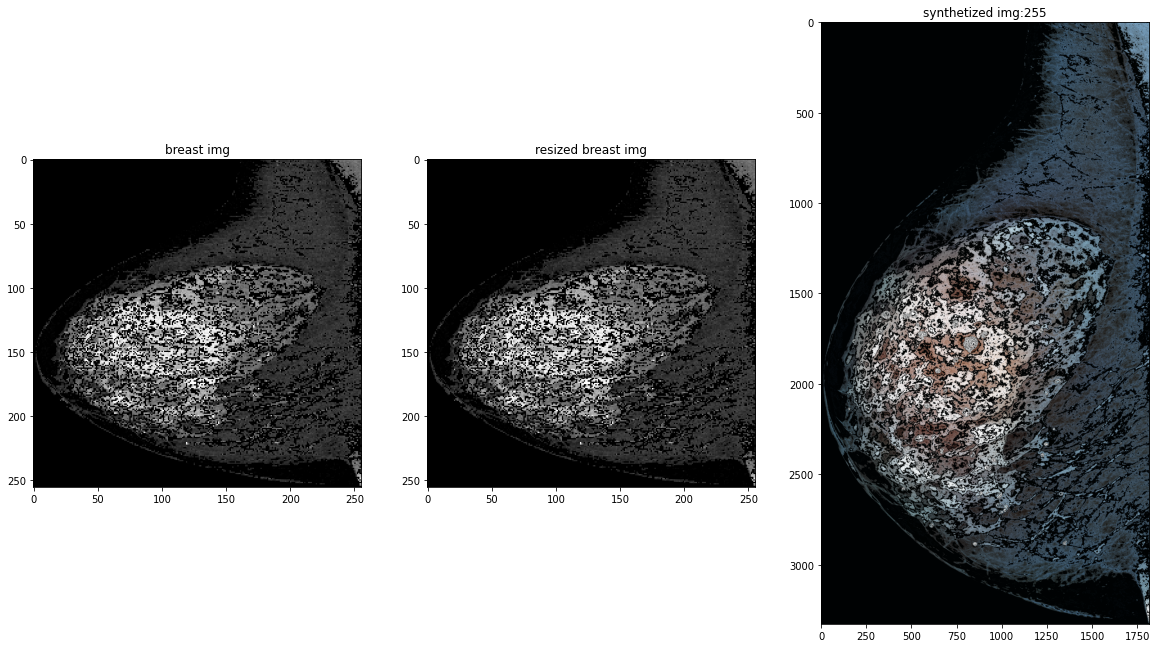

In [ ]:
dicom=glob('/content/INbreast Release 1.0/AllDICOMs/*.dcm')
xml=glob('/content/INbreast Release 1.0/AllXML/*.xml')
print("dicoms len:",len(dicom), "xml len:",len(xml))

DCM_PATH = '/content/INbreast Release 1.0/AllDICOMs/'####
XML_PATH = '/content/INbreast Release 1.0/AllXML/'   ####

xml_ids=[x.split('/')[-1].split('.')[0]for x in xml]

original_imgs, masks_list=[], []
for id in tqdm(xml_ids):
  # file=[p.split('/')[-1].split('.')[0] for p in dicom if id in p ][0]
  breast, synthetized, mass_mask, background, nbCalc= synthetized_images(DCM_PATH,XML_PATH,id)

  if not background:
    break

  original_imgs.append(breast)
  masks_list.append(mass_mask)

  # cv2.imwrite(f'Inbreast_data/AllMasks/{file}_{nbCalc}.png', mass_mask)
  # cv2.imwrite(f'Inbreast_data/AllSynthetized/{file}.png', synthetized)
  # cv2.imwrite(f'Inbreast_data/AllOriginals/{file}.png', breast)


original_imgs=np.array(original_imgs)
masks_list=np.array(masks_list)

original_imgs.shape, masks_list.shape

In [ ]:
original_imgs=np.array(original_imgs)
masks_list=np.array(masks_list)

original_imgs.shape, masks_list.shape

((343, 256, 256, 3), (343, 256, 256))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(original_imgs, masks_list, train_size=0.7)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=1/3)

In [ ]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((240, 256, 256, 3),
 (68, 256, 256, 3),
 (35, 256, 256, 3),
 (240, 256, 256),
 (68, 256, 256),
 (35, 256, 256))

In [ ]:
def load_image(file_path):
    ds = pydicom.dcmread(file_path)
    if ds.PixelRepresentation == 0:
    # Unsigned integers
      min_px = 0
      max_px = 2**ds.BitsStored - 1
    else:
      # Signed integers
        min_px = -2**(ds.BitsStored - 1)
        max_px = 2**(ds.BitsStored - 1) - 1
    return ds

In [ ]:
paths=glob('/content/INbreast Release 1.0/AllDICOMs/*.dcm')
images=[]
for p in tqdm(paths):
  images.append(load_image(p))
images = np.array(images)
print(images.shape)

  0%|          | 0/410 [00:00<?, ?it/s]

(410,)


#------

In [ ]:
DATA_DIR = '/content/Data/'

SEED = seed
batch_size=16
size=256

BATCH_SIZE = batch_size
IMAGE_SIZE=(size,size)

In [ ]:
try:
    from ImageDataAugmentor.image_data_augmentor import *
except:
    import sys
    sys.path.append("..")
    from ImageDataAugmentor.image_data_augmentor import *

In [ ]:
# augmentations
AUGMENTATIONS = albumentations.Compose([
    # flips
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    # albumentations.augmentations.geometric.rotate.SafeRotate(border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0,p=0.5),
    albumentations.Rotate(limit=90,interpolation=1,border_mode=cv2.BORDER_CONSTANT,value=0, mask_value=0,p=0.5)


    # color augmentations
    # albumentations.OneOf([
    #     albumentations.HueSaturationValue(p=1.),
    #     albumentations.RandomBrightnessContrast(p=1.),
    #     albumentations.RGBShift(p=1.)
    # ], p=0.25),

    # image quality
    # albumentations.OneOf([
    #     albumentations.GaussNoise(p=1.),
    #     albumentations.MultiplicativeNoise(p=1.),
    #     albumentations.JpegCompression(p=1.),
    #     albumentations.Downscale(scale_min=0.5,scale_max=0.99, p=1),
    # ], p=0.5),
    
    # other
    # albumentations.OneOf([
    #     albumentations.ToGray(p=1.),
    #     albumentations.RandomResizedCrop(height=IMAGE_SIZE[0], 
    #                                      width=IMAGE_SIZE[1], 
    #                                      p=1.),
        
    # ], p=0.25),
])

In [ ]:
def one_hot_encode_masks(y:np.array):
    ''' One hot encodes target masks for segmentation '''
    mask=np.where(y>0, 1, 0)

    return mask


# dataloaders
img_data_gen = ImageDataAugmentor(
    augment=AUGMENTATIONS, 
    input_augment_mode='image',
    # preprocess_input= PreProcessing,
    seed=SEED
)

In [ ]:
train_generator = img_data_gen.flow(X_train, y_train, 
                                        batch_size=BATCH_SIZE, 
                                        # target_size=IMAGE_SIZE,
                                        )

val_generator = img_data_gen.flow(X_valid, y_valid,
                                        batch_size=BATCH_SIZE, 
                                        # target_size=IMAGE_SIZE,
                                      #  subset="validation", 
                                        )

test_generator = img_data_gen.flow(X_test, y_test,
                                        batch_size=BATCH_SIZE, 
                                        # target_size=IMAGE_SIZE,
                                        )

In [ ]:
image_batch, mask_batch = next(train_generator)

In [ ]:
image_batch.shape

(16, 256, 256, 3)

In [ ]:
# visualize some augmented data
rows = 4
# image_batch, mask_batch = next(train_generator)
fix, ax = plt.subplots(rows,3, figsize=(15,18))
for i, (img,mask) in enumerate(zip(image_batch, mask_batch)):
    if i>rows-1:
        break
    
    ax[i,0].set_title(f"image shape: {img.shape}")
    ax[i,0].imshow(np.uint8(img))

    ax[i,1].set_title(f"draw mask on image")
    ax[i,1].imshow(np.uint8(img))
    ax[i,1].imshow(np.reshape(mask, (256,256)), cmap='hot', alpha=0.3)

    ax[i,2].set_title(f"mask values: {np.unique(mask)}")
    ax[i,2].imshow(np.reshape(mask, (256,256)), cmap='binary')
    
plt.show()

# Generate bbx

In [ ]:
!rm -r Augmented_Dataset
!mkdir Augmented_Dataset Augmented_Dataset/images Augmented_Dataset/masks

In [ ]:
dataset_path= "/content/Augmented_Dataset/"
images_path= "/content/Augmented_Dataset/images/"
masks_path= "/content/Augmented_Dataset/masks/"

In [ ]:
AllMasks=glob('/content/Dataset/masks/*')
AllImg=glob('/content/Dataset/images/*')

AllMasks.sort()
AllImg.sort()

print("nb img:", len(AllImg), "nb mask:", len(AllMasks))

file_ = open(dataset_path+"Yolo_data.txt", "w")
id=0

for j in trange(len(AllMasks)):

  synthetized= cv2.imread(AllImg[j])
  mask= cv2.imread(AllMasks[j]).astype(np.uint8)[:,:,0]

  for i in range(8):     
    
    transformed = transform(image=synthetized, mask=mask)
      
    cv2.imwrite(images_path+str(id)+".png", transformed['image'])
    mask=transformed['mask']
    cv2.imwrite(masks_path+str(id)+".png", mask)

    bboxess = mask_to_yolo(mask)

    gt= len(np.unique(mask))-1
    if int(gt)!=len(bboxess):
      print("Ground truth:", gt,
              "\nPredicted:", len(bboxess),
              "\n", MASK,
              # "\nbboxes:",
              )

    file_.write(images_path+str(id)+'.png'+' ')
    cnt=0
    for bbx in bboxess:
        bbx = [str(x) for x in  bbx[:4]]
        # print(bbx)
        bbx = ','.join(bbx)
        txt=''
        txt += bbx + ',0' + ' '
        # print(txt)
        file_.write(txt)
        cnt+=1
    # print(cnt)

    file_.write("\n")
    id+=1
    # break

file_.close()

nb img: 343 nb mask: 343


  0%|          | 0/343 [00:00<?, ?it/s]

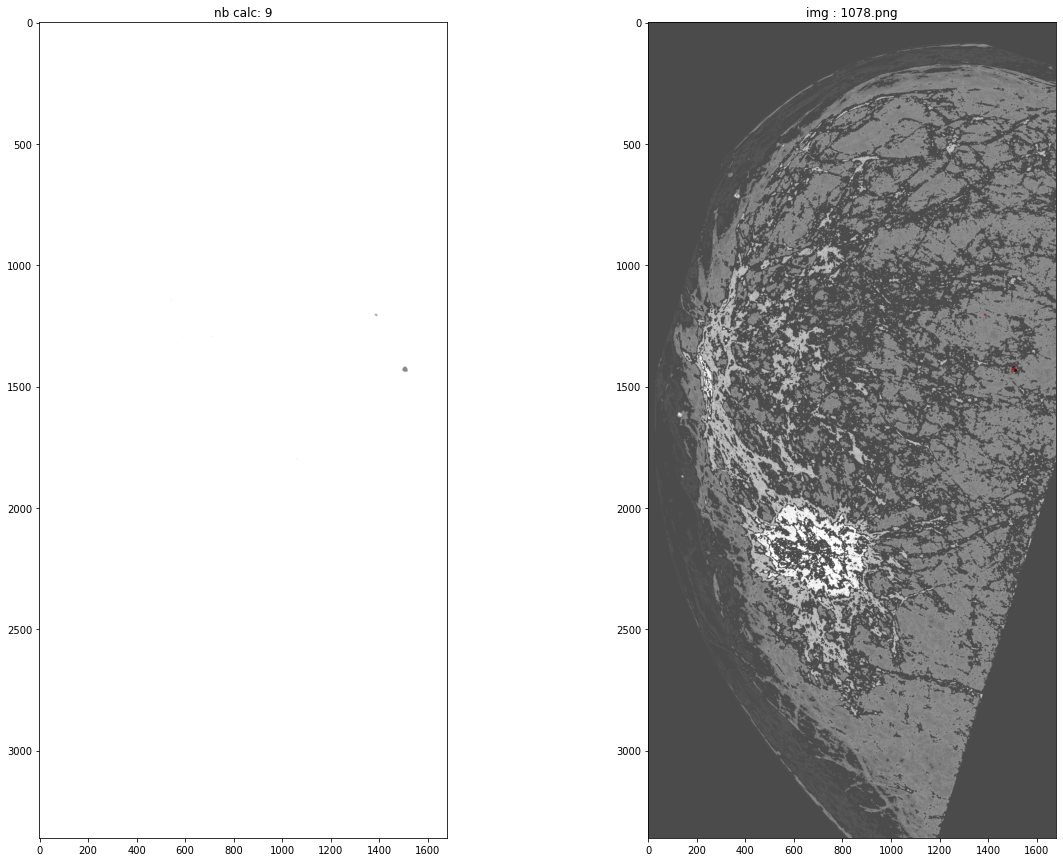

[ 0  4  5  6  8  9 10 11 12 13]
[5647681     101       1     368       2       1       2       1       1
       2]


In [ ]:
r=random.randrange(2743)
test_mask=cv2.imread(masks_path+str(r)+".png")[:,:,0]
cvals  = np.unique(test_mask)
colors = ["white"]
for i in range(len(cvals)-1):
  colors.append("red")

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list("", tuples)


f=plt.figure(figsize=(20,15))

f.add_subplot(121)
plt.imshow(test_mask, cmap="binary")
plt.title(f"nb calc: {len(np.unique(test_mask))-1}")

f.add_subplot(122)
plt.imshow(cv2.imread(images_path+str(r)+".png")[:,:,0], cmap="gray")
plt.imshow(test_mask, cmap=cmap, norm=norm, alpha=0.3)

plt.title(f"img : {r}.png")


plt.show()


print(*np.unique(test_mask, return_counts=True), sep="\n")

In [ ]:
!zip -r '/content/drive/MyDrive/INBreast_Dataset/Augmented_Dataset.zip' 'Augmented_Dataset'